In [28]:
import pandas as pd
import seaborn as sns
import numpy as np
from matplotlib import pyplot as plt

In [30]:
sample_data = pd.read_csv('zomato.csv')
sample_data.columns

Index(['url', 'address', 'name', 'online_order', 'book_table', 'rate', 'votes',
       'phone', 'location', 'rest_type', 'dish_liked', 'cuisines',
       'approx_cost(for two people)', 'reviews_list', 'menu_item',
       'listed_in(type)', 'listed_in(city)'],
      dtype='object')

In [31]:
# Dropping unwanted columns
sample_data = sample_data.drop(['url','address','name','phone','menu_item','listed_in(type)','listed_in(city)','reviews_list'], axis = 1)
sample_data.columns

# Binary Encoding
sample_data['online_order'] =  sample_data['online_order'].map({'Yes':1, 'No':0})
sample_data['book_table'] =  sample_data['book_table'].map({'Yes':1, 'No':0})

In [32]:
# Log transformation as it is right-skewed
sample_data['votes'] = np.log(sample_data['votes'] + 1)

# Imputing NaN values with the mean
sample_data['approx_cost(for two people)'] = (
    sample_data['approx_cost(for two people)']
    .str.replace(',', '')  # Remove commas
    .astype(float)  # Convert to numeric (float)
)
mean_value = sample_data['approx_cost(for two people)'].mean()
sample_data['approx_cost(for two people)'] = sample_data['approx_cost(for two people)'].fillna(mean_value)
# Log transformation as it is right skewed
sample_data['approx_cost(for two people)'] = np.log(sample_data['approx_cost(for two people)'] + 1)

In [33]:
# Clean - remove NaNs
sample_data.dropna(subset=['location'], inplace=True)

# One hot encoding for location
sample_data = pd.get_dummies(sample_data, columns=['location'], prefix='location', dummy_na = True)

In [34]:
# Clean - explode and then remove NaNs
sample_data.dropna(subset=['rest_type'], inplace=True)
sample_data['rest_type'] = sample_data['rest_type'].str.split(',')
sample_data = sample_data.explode('rest_type')
sample_data['rest_type'] = sample_data['rest_type'].str.strip()

# One hot encoding for rest_type
sample_data = pd.get_dummies(sample_data, columns=['rest_type'], prefix='rest_type', dummy_na = True)

In [35]:
# Clean - explode and then remove NaNs
sample_data.dropna(subset=['cuisines'], inplace=True)
sample_data['cuisines'] = sample_data['cuisines'].str.split(',')
sample_data = sample_data.explode('cuisines')
sample_data['cuisines'] = sample_data['cuisines'].str.strip()

# One hot encoding for rest_type
sample_data = pd.get_dummies(sample_data, columns=['cuisines'], prefix='cuisines', dummy_na = True)

In [36]:
# Binary encoding for dish_liked

sample_data['dish_liked'] = sample_data['dish_liked'].apply(lambda x: 1 if pd.notna(x) and x.strip() != '' else 0)

In [37]:
sample_data.columns

Index(['online_order', 'book_table', 'rate', 'votes', 'dish_liked',
       'approx_cost(for two people)', 'location_BTM', 'location_Banashankari',
       'location_Banaswadi', 'location_Bannerghatta Road',
       ...
       'cuisines_Tamil', 'cuisines_Tea', 'cuisines_Tex-Mex', 'cuisines_Thai',
       'cuisines_Tibetan', 'cuisines_Turkish', 'cuisines_Vegan',
       'cuisines_Vietnamese', 'cuisines_Wraps', 'cuisines_nan'],
      dtype='object', length=234)

In [46]:
 sample_data.to_csv('cleaned_data.csv', index=False)

In [48]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

df = pd.read_csv(file_path)

# Preprocess the 'rate' column
df['rate'] = df['rate'].str.replace('/5', '', regex=True)  # Remove '/5'
df['rate'] = df['rate'].replace({'NEW': np.nan, '-': np.nan}).astype(float)  # Convert valid numbers to float

# Drop rows where 'rate' is NaN for proper stratification
df_clean = df.dropna(subset=['rate'])

# Define stratification variable
stratify_col = df_clean['rate']

# Split into training (70%) and remaining (30%)
train_df, temp_df = train_test_split(df_clean, test_size=0.3, stratify=stratify_col, random_state=42)

# Further split remaining data into validation (15%) and testing (15%)
stratify_col_temp = temp_df['rate']
val_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=stratify_col_temp, random_state=42)

# Display dataset sizes
print(f"Training Set: {len(train_df)}")
print(f"Validation Set: {len(val_df)}")
print(f"Testing Set: {len(test_df)}")

# Save the partitions to CSV files if needed
train_df.to_csv("train_data.csv", index=False)
val_df.to_csv("val_data.csv", index=False)
test_df.to_csv("test_data.csv", index=False)


Training Set: 87873
Validation Set: 18830
Testing Set: 18831


In [50]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_absolute_error, r2_score

# Load the dataset
file_path = "train_data.csv"  # Update this path if needed
df = pd.read_csv(file_path)

# Define features (X) and target variable (y)
X = df.drop(columns=['rate'])  # Excluding the target variable
y = df['rate']  # Target variable

# Split into training (80%) and validation (20%) sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train Ridge Regression model
ridge_model = Ridge(alpha=1.0)  # Alpha controls regularization strength
ridge_model.fit(X_train, y_train)

# Make predictions on validation data
y_pred = ridge_model.predict(X_val)

# Evaluate the model
mae = mean_absolute_error(y_val, y_pred)
r2 = r2_score(y_val, y_pred)

# Display results
print(f"Ridge Regression Performance:")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"R² Score: {r2:.4f}")

# Save trained model if needed
import joblib
joblib.dump(ridge_model, "ridge_regression_model.pkl")


Ridge Regression Performance:
Mean Absolute Error (MAE): 0.2215
R² Score: 0.5521


['ridge_regression_model.pkl']

In [50]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_absolute_error, r2_score

# Load the dataset
file_path = "train_data.csv"  # Update this path if needed
df = pd.read_csv(file_path)

# Define features (X) and target variable (y)
X = df.drop(columns=['rate'])  # Excluding the target variable
y = df['rate']  # Target variable

# Split into training (80%) and validation (20%) sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train Ridge Regression model
ridge_model = Ridge(alpha=1.0)  # Alpha controls regularization strength
ridge_model.fit(X_train, y_train)

# Make predictions on validation data
y_pred = ridge_model.predict(X_val)

# Evaluate the model
mae = mean_absolute_error(y_val, y_pred)
r2 = r2_score(y_val, y_pred)

# Display results
print(f"Ridge Regression Performance:")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"R² Score: {r2:.4f}")

# Save trained model if needed
import joblib
joblib.dump(ridge_model, "ridge_regression_model.pkl")


Ridge Regression Performance:
Mean Absolute Error (MAE): 0.2215
R² Score: 0.5521


['ridge_regression_model.pkl']

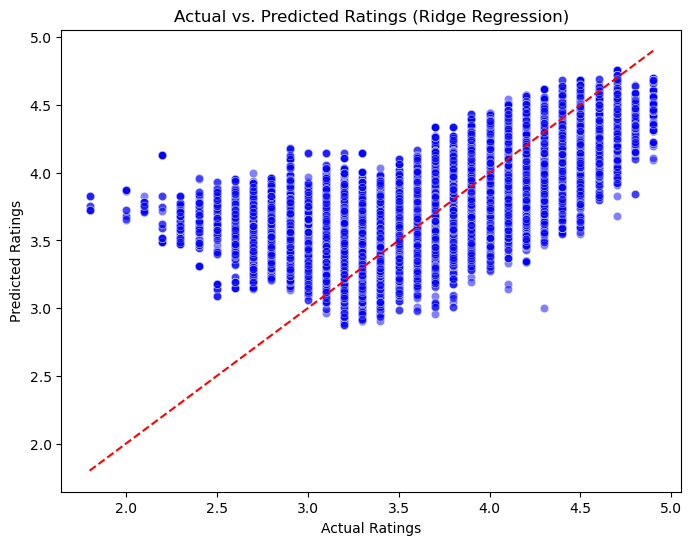

In [60]:
import joblib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load the Ridge Regression model from the .pkl file
model_path = "ridge_regression_model.pkl"  # Update this if needed
model = joblib.load(model_path)

# Load new data (assuming the same format as training features)
new_data_path = "train_data.csv"  # Replace with actual test data path if different
X_new = pd.read_csv(new_data_path)

# Drop the target variable 'rate' if it's in the dataset
if 'rate' in X_new.columns:
    y_actual = X_new['rate']  # Store actual ratings
    X_new = X_new.drop(columns=['rate'])
else:
    y_actual = None

# Make predictions
predictions = model.predict(X_new)

# ===================== VISUALIZATION ===================== #

if y_actual is not None:
    # Scatter Plot: Predictions vs Actual Ratings
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=y_actual, y=predictions, alpha=0.5, color="blue")
    plt.plot([y_actual.min(), y_actual.max()], [y_actual.min(), y_actual.max()], 'r--')  # Ideal fit line
    plt.xlabel("Actual Ratings")
    plt.ylabel("Predicted Ratings")
    plt.title("Actual vs. Predicted Ratings (Ridge Regression)")
    plt.show()


Best Alpha: 0.46415888336127775
Optimized RMSE: 0.30368251035386556


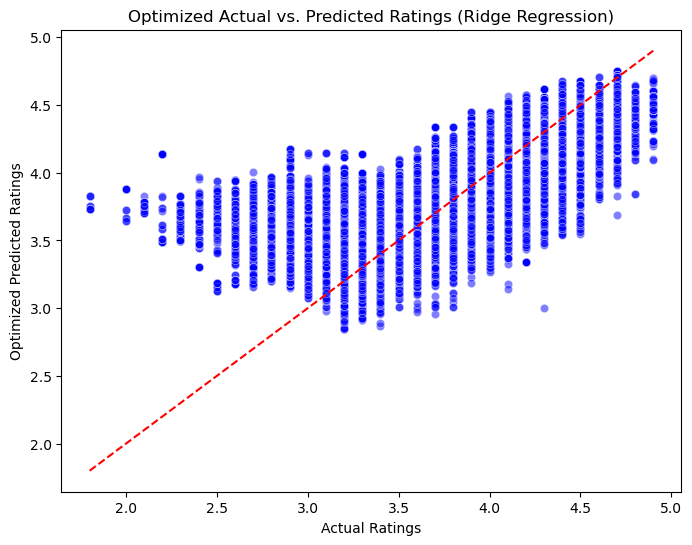

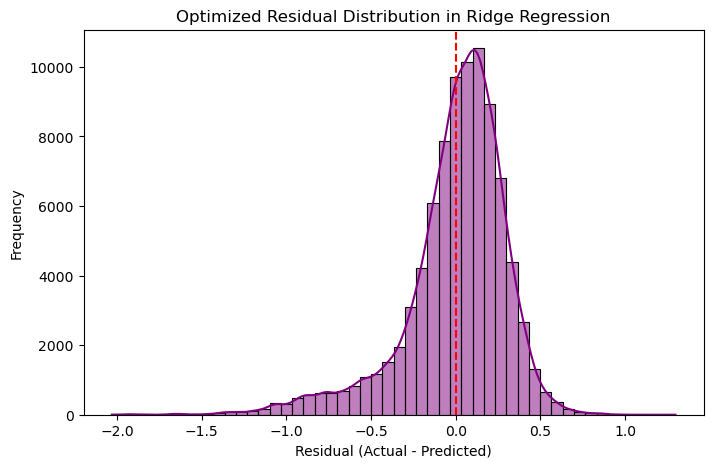

In [64]:
import joblib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error

# Load Ridge Regression model
model_path = "ridge_regression_model.pkl"
model = joblib.load(model_path)

# Load train dataset
train_data_path = "train_data.csv"
train_data = pd.read_csv(train_data_path)

# Extract target variable
if 'rate' in train_data.columns:
    y_train = train_data['rate']
    X_train = train_data.drop(columns=['rate'])
else:
    raise ValueError("Target variable 'rate' not found in training dataset")

# Define parameter grid for Ridge regression
param_grid = {'alpha': np.logspace(-3, 3, 10)}

# Perform Grid Search with cross-validation
ridge = Ridge()
grid_search = GridSearchCV(ridge, param_grid=param_grid, cv=3, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)

# Get the best model
best_ridge = grid_search.best_estimator_

# Make predictions with the optimized model
optimized_predictions = best_ridge.predict(X_train)

# Compute RMSE
rmse = np.sqrt(mean_squared_error(y_train, optimized_predictions))
print(f"Best Alpha: {grid_search.best_params_['alpha']}")
print(f"Optimized RMSE: {rmse}")

# Visualization
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_train, y=optimized_predictions, alpha=0.5, color="blue")
plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'r--')
plt.xlabel("Actual Ratings")
plt.ylabel("Optimized Predicted Ratings")
plt.title("Optimized Actual vs. Predicted Ratings (Ridge Regression)")
plt.show()

plt.figure(figsize=(8, 5))
sns.histplot(y_train - optimized_predictions, bins=50, kde=True, color="purple")
plt.axvline(0, color='red', linestyle='--')
plt.xlabel("Residual (Actual - Predicted)")
plt.ylabel("Frequency")
plt.title("Optimized Residual Distribution in Ridge Regression")
plt.show()

Best Parameters: {'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': 20}
Optimized RMSE: 0.17717504408247542


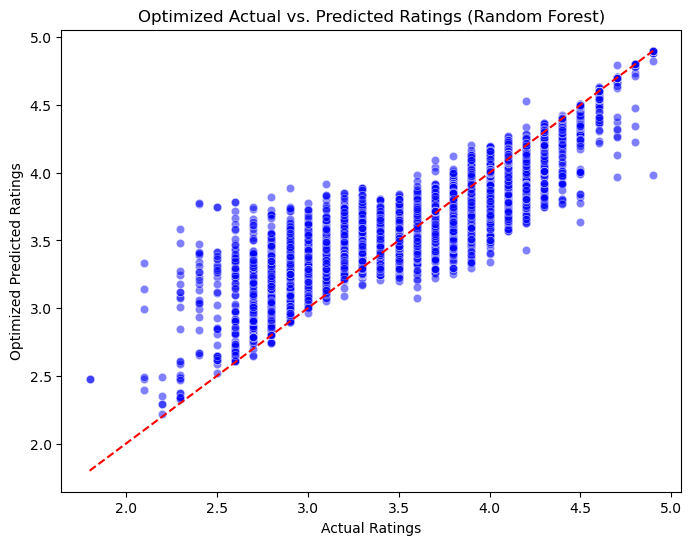

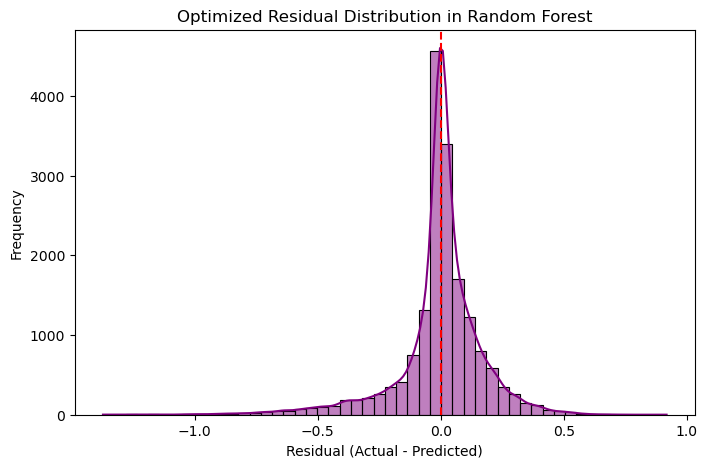

In [3]:
import joblib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

# Load train dataset
train_data_path = "train_data.csv"
train_data = pd.read_csv(train_data_path)

# Extract target variable
if 'rate' in train_data.columns:
    y_train = train_data['rate']
    X_train = train_data.drop(columns=['rate'])
else:
    raise ValueError("Target variable 'rate' not found in training dataset")

# Split data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Define parameter distribution for Random Forest
param_dist = {
    'n_estimators': [50, 100],  # Reduced number of estimators
    'max_depth': [10, 20],  # Limited depth for faster training
    'min_samples_split': [2, 5],  # Fewer options to speed up search
    'min_samples_leaf': [1, 2]
}

# Perform Randomized Search with cross-validation
rf = RandomForestRegressor(random_state=42)
random_search = RandomizedSearchCV(rf, param_distributions=param_dist, cv=3, scoring='neg_mean_squared_error', n_iter=10, random_state=42, n_jobs=-1)
random_search.fit(X_train, y_train)

# Get the best model
best_rf = random_search.best_estimator_

# Make predictions with the optimized model
optimized_predictions = best_rf.predict(X_val)

# Compute RMSE
rmse = np.sqrt(mean_squared_error(y_val, optimized_predictions))
print(f"Best Parameters: {random_search.best_params_}")
print(f"Optimized RMSE: {rmse}")

# Visualization
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_val, y=optimized_predictions, alpha=0.5, color="blue")
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--')
plt.xlabel("Actual Ratings")
plt.ylabel("Optimized Predicted Ratings")
plt.title("Optimized Actual vs. Predicted Ratings (Random Forest)")
plt.show()

plt.figure(figsize=(8, 5))
sns.histplot(y_val - optimized_predictions, bins=50, kde=True, color="purple")
plt.axvline(0, color='red', linestyle='--')
plt.xlabel("Residual (Actual - Predicted)")
plt.ylabel("Frequency")
plt.title("Optimized Residual Distribution in Random Forest")
plt.show()